In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from xgboost.sklearn import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection

#!pip install catboost
from catboost import CatBoostClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ModuleNotFoundError: ignored

#Lectura de archivos

In [0]:
df_conv = pd.read_csv('drive/My Drive/Desafios DS/DESAFIO FINAL/conversiones.csv')

In [0]:
data = pd.read_csv('drive/My Drive/Desafios DS/DESAFIO FINAL/pageviews.csv')
disp = pd.read_csv('drive/My Drive/Desafios DS/DESAFIO FINAL/device_data.csv')

####Creacion de las nuevas columnas y merge

In [0]:
#data --> pageviews
#disp --> devices

#mer  --> merge de pageview y devices

#Se crea una nueva columna fecha que no tiene los segundos para poder mergear pageview con devices
disp['fecha']=disp['FEC_EVENT'].str.slice(0,16)
data['fecha']=data['FEC_EVENT'].str.slice(0,16)

#Se ordena device por usuario y por fecha
disp=disp.sort_values(['USER_ID','FEC_EVENT'])
#Se cuentan la cantidad de conexiones por usuario
disp['conexiones']=(disp.groupby('USER_ID').cumcount())+1

#Se hace el merge por fecha y por usuario con inner_left
mer = pd.merge(data, disp, left_on=['fecha','USER_ID'], right_on=['fecha','USER_ID'], how='left')

#Se borra la columna creada en el merge dejando solo FEC_EVENT_x
mer.drop(columns=['FEC_EVENT_y'],inplace=True)

#Se renombra FEC_EVENT y se cambia el tipo de dato a time
mer.rename(columns={'FEC_EVENT_x':'FEC_EVENT'},inplace=True)
mer['FEC_EVENT']=pd.to_datetime(mer['FEC_EVENT'])

#Se ordena el nuevo dataframe por usuario y por fecha
mer=mer.sort_values(['USER_ID','FEC_EVENT'])

#Se borran todos los datos menores al 12-01, ya que en devices no hay datos menores a esa fecha
mer.drop(mer.loc[mer['fecha']< '2018-01-12 00:00'].index, inplace=True)

#Se completan los nulos que quedaron del merge con un foward fill
mer.fillna(method='ffill', inplace=True)



#Se crea una nueva columna con los segundo que estuvo en cada pagina
mer['dif']=(mer['FEC_EVENT'].shift(periods=-1)-mer['FEC_EVENT']).dt.total_seconds()

#Se crea una nueva columna que dice cuando fue el evento de la ultima conexion
mer['ult_conex']=(mer['conexiones'].shift(periods=-1)!=mer['conexiones']).astype(int)


#Se pone un valor en segundos para los eventos de la ultima conexion ya que en el dif quedan valores erroneos
mer.loc[mer['ult_conex']==1,'dif']=10



In [0]:
#Se graba el nuevo dataframe
mer.to_csv('drive/My Drive/Desafios DS/DESAFIO FINAL/pablo_merge.csv', index=False)

In [0]:
#Se lee el nuevo dataframe
mer= pd.read_csv('drive/My Drive/Desafios DS/DESAFIO FINAL/pablo_merge.csv')

#funciones


In [0]:
#Definimos una funcion para mostrar las metricas de los modelos
def probar_modelo(y_test,y_pred,titulo):
    print('Reporte del modelo ',titulo)
    print(' ')
    print(classification_report(y_test,y_pred))
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(' ')
    print(confusion_matrix(y_test,y_pred))
    
        
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos');

In [0]:
def roc(proba_train,y_train,proba_test,y_test,title):
    sns.set(style='darkgrid', font_scale=1, font='Ricty',    rc={"lines.linewidth": 1.5, 'grid.linestyle': '--'})

    fpr_log,tpr_log,thr_log = roc_curve(y_train, proba_train[:,1])
    fpr_log_CW,tpr_log_CW,thr_log_CW = roc_curve(y_test, proba_test[:,1])

    plt.figure(figsize=(12,6))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve - '+title)
    plt.plot(fpr_log,tpr_log)

    plt.plot(fpr_log_CW,tpr_log_CW)

    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.legend(['train','test'])
    plt.show()

    print('train   =', auc(fpr_log, tpr_log))
    print('test    =', auc(fpr_log_CW, tpr_log_CW))


In [0]:

def ventana_nueva(min,max,data,df_conv):
    #La funcion devueve un X y un y en el periodo pedido
    
    #Se procesan los datos del archivo pageviews, dentro de las fechas pedidas, poniendo el promedio por usuario
    data['FEC_EVENT'] = pd.to_datetime(data['FEC_EVENT'])
    data = data[((data.FEC_EVENT.dt.month >= min) & ( data.FEC_EVENT.dt.month < max))]
    X = []
    for c in data.drop(["USER_ID", "FEC_EVENT",'fecha' ,'CONNECTION_SPEED',	'IS_MOBILE_DEVICE',	'conexiones' ,'dif'], axis=1).columns:
        temp = pd.crosstab(data.USER_ID, data[c])
        temp.columns = [c + "_" + str(v) for v in temp.columns]
        X.append(temp.apply(lambda x: x / x.sum(), axis=1))
    X = pd.concat(X, axis=1)
    
    #Se busca en el archivo conversiones y se asigna a cada usuario si se convirtio en los 3 meses siguientes al periodo analizado
    y_prev = df_conv
    
    # Se crea una columna binaria que se activa si el usuario ya se convirtio
    #X['convirtio']=0
    #idx = set(y_prev[(y_prev.mes >= min) & (y_prev.mes < max)].USER_ID.unique()).intersection(
    #        set(X.index))
    #X.loc[list(idx),'convirtio'] = 1

    # Se crea una columna con la cantidad de conexiones que tuvo el usuario
    conex=mer.groupby('USER_ID')[['conexiones']].max()
    X=pd.merge(X, conex, left_on=['USER_ID'], right_on=['USER_ID'], how='left',right_index=True,suffixes=('', '_CONEX'))
    
    # Se crean columnas con la cantidad de segundos que estuvo el usuario en cada pagina
    seg_pagina=data.loc[(data.FEC_EVENT.dt.month >= min) & (data.FEC_EVENT.dt.month <max)].groupby(by=['USER_ID','PAGE'])['dif'].sum().unstack(level=1).add_prefix('SEG_').rename_axis([None], axis=1).reset_index()
    seg_pagina.fillna(0,inplace=True)
    X = pd.merge(X, seg_pagina, left_on=['USER_ID'], right_on=['USER_ID'], how='left',right_index=True,suffixes=('', '_SEG'))
    X.fillna(0,inplace=True)
    
    #Se pone como limite el mes 10 ya que busca el target(y) en los 3 meses posteriores, y no hay datos despues del mes 12
    if (max>=10):
        max=10
    
    y = pd.Series(0, index=X.index)
    idx = set(y_prev[(y_prev.mes >= max) & (y_prev.mes < max+3)].USER_ID.unique()).intersection(
            set(X.index))
    y.loc[list(idx)] = 1
    
    return X, y

In [0]:
def entrenar_lgbm(X,y):
    from lightgbm import LGBMClassifier
    from sklearn import model_selection
  
    X_train=X
    y_train=y
    
    fi = []
    test_probs = []
    i = 0
    for train_idx, valid_idx in model_selection.KFold(n_splits=10, shuffle=True).split(X_train):
        i += 1
        Xt = X_train.iloc[train_idx]
        yt = y_train.loc[X_train.index].iloc[train_idx]

        Xv = X_train.iloc[valid_idx]
        yv = y_train.loc[X_train.index].iloc[valid_idx]

        learner = LGBMClassifier(n_estimators=10000)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)],verbose=False)

        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    fi = pd.concat(fi, axis=1).mean(axis=1)
    return learner, fi



In [0]:
def entrenar_log(X,y):
    
    lg = LogisticRegression( class_weight='balanced', max_iter=500, penalty='l2',solver='lbfgs')

    lg.fit(X,y)
    return lg


#Creacion de train y test

In [0]:
X_train,y_train = ventana_nueva(1,7,mer,df_conv)

In [0]:
X_test,y_test =ventana_nueva(7,10,mer,df_conv)

In [0]:
# Unifico las columnas entre el train y el test
features = list(set(X_train.columns).intersection(set(X_test.columns)))
X_train = X_train[features]
X_test = X_test[features]

###Guardo train y test


In [0]:
train = X_train.copy()
train['y']=y_train

test = X_test.copy()
test['y']=y_test

#train.to_csv('drive/My Drive/Final/train.csv', index=False)
#test.to_csv('drive/My Drive/Final/test.csv', index=False)

train.to_csv('drive/My Drive/Final/short_train.csv', index=False)
test.to_csv('drive/My Drive/Final/short_test.csv', index=False)

#Leo train y test

In [0]:
#train = pd.read_csv('drive/My Drive/Final/train.csv')
#test= pd.read_csv('drive/My Drive/Final/test.csv')

train = pd.read_csv('drive/My Drive/Final/short_train.csv')
test= pd.read_csv('drive/My Drive/Final/short_test.csv')


In [0]:
X_train=train.drop(columns=['y'])
y_train=train['y']
X_test=test.drop(columns=['y'])
y_test=test['y']

#Stacking


In [43]:
clf1 =  XGBClassifier(  n_estimators=300, 
                        learning_rate=0.048646464646464646, 
                        max_depth=1, 
                        min_child_weight=5,
                        max_leaf_nodes=1, 
                        gamma=0.4686868686868687, 
                        colsample_bytree=0.5363636363636364, 
                        eval_metric='auc', 
                        reg_lambda=61.62, 
                        reg_alpha=0.4853636363636364, 
                        scale_pos_weight=46.63764638674664,
                       tree_method= 'gpu_hist')
 
clf2 = LogisticRegression(class_weight='balanced',
                          max_iter=500, 
                          penalty='l2',
                          solver='lbfgs')

clf3 = LGBMClassifier(n_estimators=10000,
                      eval_metric="auc",
                      verbose=0)

clf4 = CatBoostClassifier(eval_metric='AUC',
                          n_estimators=300, 
                          learning_rate=0.03246464646464646, 
                          max_depth=2, 
                          scale_pos_weight=23.648100542702085,
                          verbose=0)

lr = LogisticRegression(class_weight='balanced',solver='lbfgs')

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4],
                            use_probas=True,
                            meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, clf4, sclf],
                      ['XGB', 
                       'LG',
                       'LGBM',
                       'Cat',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='roc_auc',verbose=3,n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.84 (+/- 0.01) [XGB]
Accuracy: 0.55 (+/- 0.00) [LG]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.77 (+/- 0.02) [LGBM]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.83 (+/- 0.01) [Cat]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.84 (+/- 0.01) [StackingClassifier]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 10.4min finished


In [44]:
sclf.fit(X_train.values,y_train.values)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


StackingCVClassifier(classifiers=[XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.5363636363636364,
                                                eval_metric='auc',
                                                gamma=0.4686868686868687,
                                                learning_rate=0.048646464646464646,
                                                max_delta_step=0, max_depth=1,
                                                max_leaf_nodes=1,
                                                min_child_weight=5,
                                                missing=None, n_estimators=300,
                                                n_jobs=1, nthread=None,...
                                                       

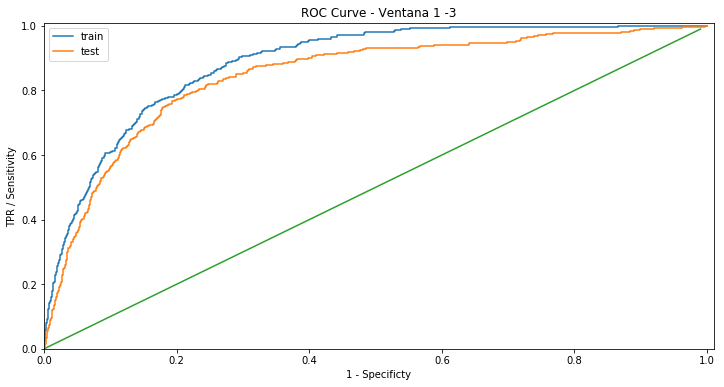

train   = 0.8846640032130552
test    = 0.8447260781878038


In [45]:
y_pred_train_stack = sclf.predict(X_train.values)
y_proba_train_stack = sclf.predict_proba(X_train.values)

y_pred_test_stack = sclf.predict(X_test.values)
y_proba_test_stack = sclf.predict_proba(X_test.values)

roc(y_proba_train_stack,y_train.values,y_proba_test_stack,y_test.values)

#sm = pd.read_csv("drive/My Drive/Final/sampleSubmission.csv")
#sm['SCORE'] = y_proba_test_stack[:,1]
#sm.to_csv("drive/My Drive/Final/subm_stack_lg.csv", index=False)

Reporte del modelo  Stacking
 
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     10970
           1       0.09      0.84      0.17       386

    accuracy                           0.72     11356
   macro avg       0.54      0.78      0.50     11356
weighted avg       0.96      0.72      0.81     11356

Accuracy:  0.7182986967241987
 
[[7832 3138]
 [  61  325]]


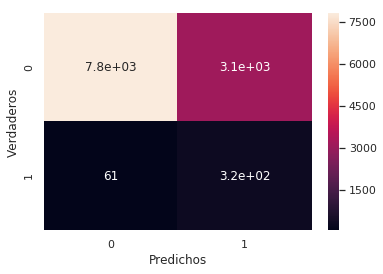

In [69]:
probar_modelo(y_test,y_pred_test_stack,'Stacking')

In [0]:
X_train.columns

Index(['SEG_1405', 'SEG_557', 'PAGE_1801', 'SEG_239', 'PAGE_21', 'SEG_81',
       'SEG_460', 'PAGE_1177', 'PAGE_2', 'SEG_376',
       ...
       'PAGE_13', 'PAGE_148', 'SEG_984', 'PAGE_1263', 'SEG_633', 'SEG_456',
       'CONTENT_CATEGORY_BOTTOM_55', 'PAGE_1249', 'PAGE_274', 'SEG_182'],
      dtype='object', length=3512)

#Vecstack

In [0]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19879 sha256=8144e994cf7b09c893e06bd87e7a2cc510407826c7e09acdc9cf2034a412f8ed
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [0]:
from vecstack import stacking

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
a

In [0]:
models = [
    XGBClassifier( n_estimators=300, 
                  learning_rate=0.048646464646464646, 
                  max_depth=1, 
                  min_child_weight=5,
                  max_leaf_nodes=1, 
                  gamma=0.4686868686868687, 
                  colsample_bytree=0.5363636363636364, 
                  eval_metric='auc', 
                  reg_lambda=61.62, 
                  reg_alpha=0.4853636363636364, 
                  scale_pos_weight=46.63764638674664),
             
    CatBoostClassifier(eval_metric='AUC',
                       n_estimators=300, 
                       learning_rate=0.03246464646464646, 
                       max_depth=2, 
                       scale_pos_weight=23.648100542702085)
        
 
]

In [0]:
X_train.shape

(11528, 3512)

In [0]:
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=roc_auc_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)  

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [XGBClassifier]
    fold  0:  [0.77138827]
    fold  1:  [0.79875067]
    fold  2:  [0.80377760]
    fold  3:  [0.77587688]
    ----
    MEAN:     [0.78744836] + [0.01401974]
    FULL:     [0.78740136]

model  1:     [CatBoostClassifier]
0:	total: 38.6ms	remaining: 11.5s
1:	total: 79ms	remaining: 11.8s
2:	total: 118ms	remaining: 11.7s
3:	total: 157ms	remaining: 11.6s
4:	total: 197ms	remaining: 11.6s
5:	total: 236ms	remaining: 11.6s
6:	total: 280ms	remaining: 11.7s
7:	total: 325ms	remaining: 11.8s
8:	total: 362ms	remaining: 11.7s
9:	total: 400ms	remaining: 11.6s
10:	total: 440ms	remaining: 11.6s
11:	total: 485ms	remaining: 11.6s
12:	total: 524ms	remaining: 11.6s
13:	total: 563ms	remaining: 11.5s
14:	total: 602ms	remaining: 11.4s
15:	total: 640ms	remaining: 11.4s
16:	total: 680ms	remaining: 11.3s
17:	total: 719ms	remaining: 11.3s
18:	total: 762ms	re

In [0]:
# Initialize 2nd level model
model =     XGBClassifier( n_estimators=300, 
                  learning_rate=0.048646464646464646, 
                  max_depth=1, 
                  min_child_weight=5,
                  max_leaf_nodes=1, 
                  gamma=0.4686868686868687, 
                  colsample_bytree=0.5363636363636364, 
                  eval_metric='auc', 
                  reg_lambda=61.62, 
                  reg_alpha=0.4853636363636364, 
                  scale_pos_weight=46.63764638674664)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.74049332]


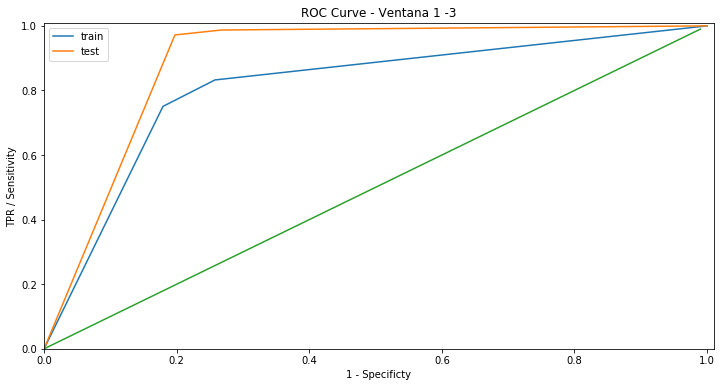

train   = 0.8094686193694958
test    = 0.8924299168146386


In [0]:
y_pred_train_Best = model.predict(S_train)
y_proba_train_Best = model.predict_proba(S_train)

y_pred_test_Best = model.predict(S_test)
y_proba_test_Best = model.predict_proba(S_test)
roc(y_proba_train_Best,y_train,y_proba_test_Best,y_test)

#LG


In [24]:
pp = entrenar_log(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


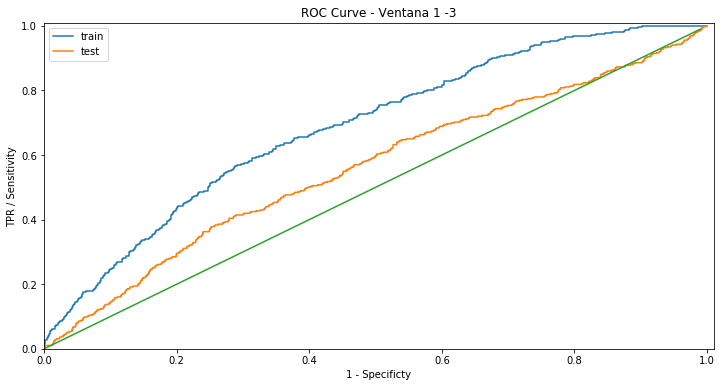

train   = 0.6866263625538152
test    = 0.56020470335961


In [48]:
y_pred_train_LG = pp.predict(X_train)
y_proba_train_LG = pp.predict_proba(X_train)

y_pred_test_LG = pp.predict(X_test)
y_proba_test_LG = pp.predict_proba(X_test)
roc(y_proba_train_LG,y_train,y_proba_test_LG,y_test)

Reporte del modelo  Logistic
 
              precision    recall  f1-score   support

           0       0.97      0.47      0.63     10970
           1       0.04      0.63      0.08       386

    accuracy                           0.48     11356
   macro avg       0.51      0.55      0.35     11356
weighted avg       0.94      0.48      0.61     11356

Accuracy:  0.47534343078548785
 
[[5154 5816]
 [ 142  244]]


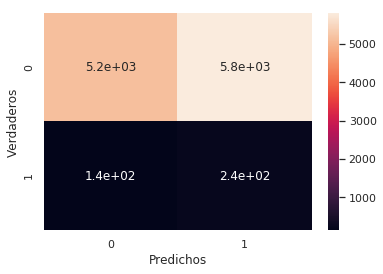

In [70]:
probar_modelo(y_test,y_pred_test_LG,'Logistic')

#LGBM

In [0]:
model_lgbm, f=entrenar_lgbm(X_train,y_train)

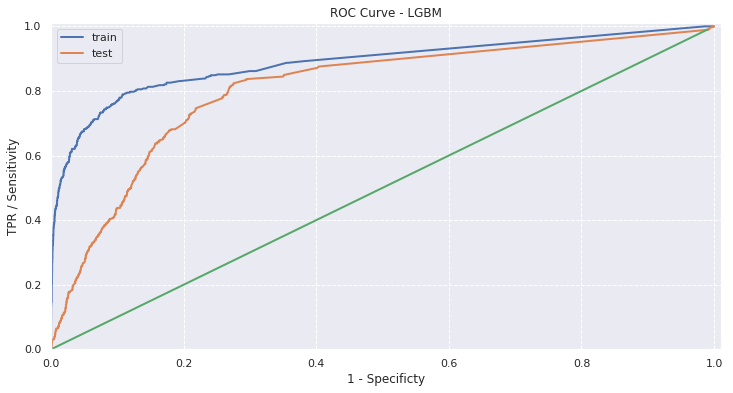

train   = 0.887122413173526
test    = 0.8074073899140849


In [80]:
y_pred_train_lgbm = model_lgbm.predict(X_train)
y_proba_train_lgbm = model_lgbm.predict_proba(X_train)

y_pred_test_lgbm = model_lgbm.predict(X_test)
y_proba_test_lgbm = model_lgbm.predict_proba(X_test)
roc(y_proba_train_lgbm,y_train,y_proba_test_lgbm,y_test,'LGBM')

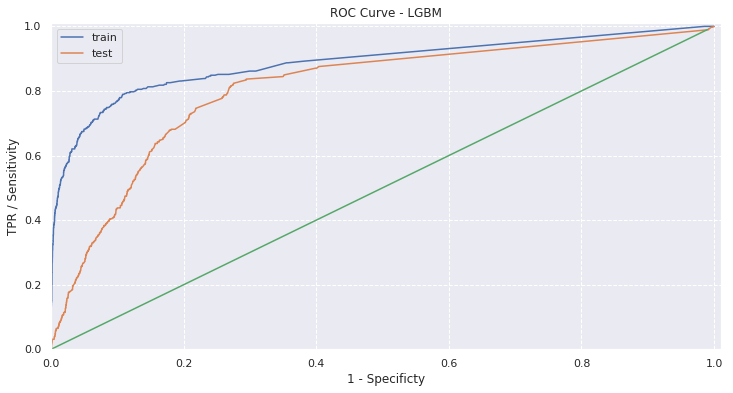

train   = 0.887122413173526
test    = 0.8074073899140849


In [86]:
roc(y_proba_train_lgbm,y_train,y_proba_test_lgbm,y_test,'LGBM')

#CatBoost

In [33]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 61.9MB 58.2MB/s 


In [0]:
weigth_0= (float(np.sum(y_train == 1)))/ float(np.sum(y_train== 0))
weigth_1= (float(np.sum(y_train == 0)))/ float(np.sum(y_train == 1))
     

In [0]:
from catboost import CatBoostClassifier
#model_cat = CatBoostClassifier(class_weights=[1, weigth_1],eval_metric='AUC',task_type='GPU',n_estimators=300, learning_rate=0.03246464646464646, max_depth=2, silent=True)
model_cat = CatBoostClassifier(eval_metric='AUC',n_estimators=300, learning_rate=0.03246464646464646, max_depth=2, scale_pos_weight=23.648100542702085,verbose=0)

In [41]:
model_cat.fit(X_train, y_train)

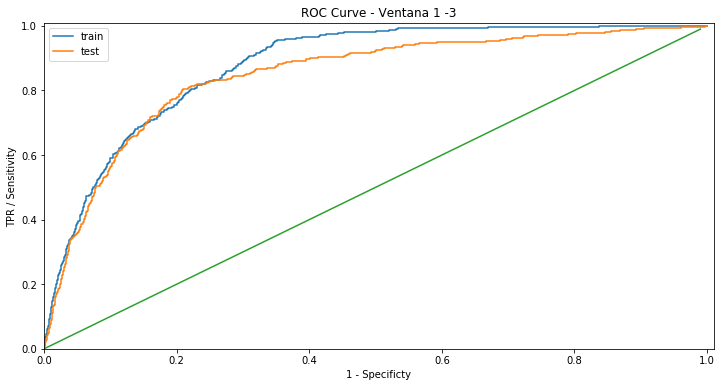

train   = 0.8773667509858771
test    = 0.8464318607979368


In [36]:
y_pred_train_cat = model_cat.predict(X_train)
y_proba_train_cat = model_cat.predict_proba(X_train)

y_pred_test_cat = model_cat.predict(X_test)
y_proba_test_cat = model_cat.predict_proba(X_test)
roc(y_proba_train_cat,y_train,y_proba_test_cat,y_test)

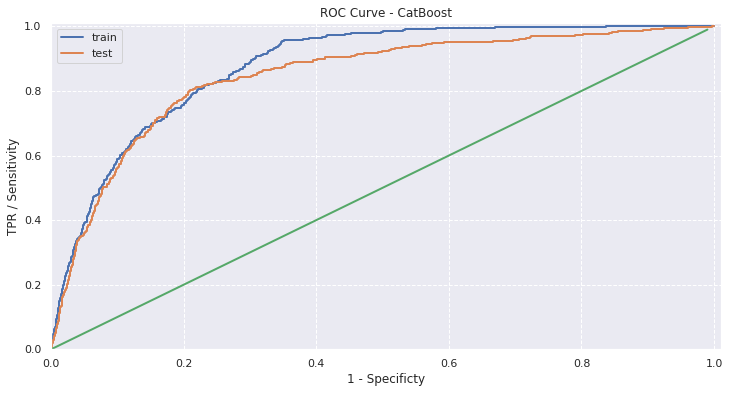

train   = 0.8773667509858771
test    = 0.8464318607979368


In [82]:
roc(y_proba_train_cat,y_train,y_proba_test_cat,y_test,'CatBoost')

In [0]:
sm = pd.read_csv("drive/My Drive/Final/sampleSubmission.csv")
sm['SCORE'] = y_proba_test_Best[:,1]
sm.to_csv("submission_cat.csv", index=False)

#XGBoost

In [0]:
model = XGBClassifier(  n_estimators=300, 
                        learning_rate=0.048646464646464646, 
                        max_depth=1, 
                        min_child_weight=5,
                        max_leaf_nodes=1, 
                        gamma=0.4686868686868687, 
                        colsample_bytree=0.5363636363636364, 
                        eval_metric='auc', 
                        reg_lambda=61.62, 
                        reg_alpha=0.4853636363636364, 
                        scale_pos_weight=46.63764638674664,
                       tree_method= 'gpu_hist')

In [38]:
%%time
model.fit(X_train,y_train)

CPU times: user 12.1 s, sys: 8.79 s, total: 20.9 s
Wall time: 20.9 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5363636363636364,
              eval_metric='auc', gamma=0.4686868686868687,
              learning_rate=0.048646464646464646, max_delta_step=0, max_depth=1,
              max_leaf_nodes=1, min_child_weight=5, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.4853636363636364, reg_lambda=61.62,
              scale_pos_weight=46.63764638674664, seed=None, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)

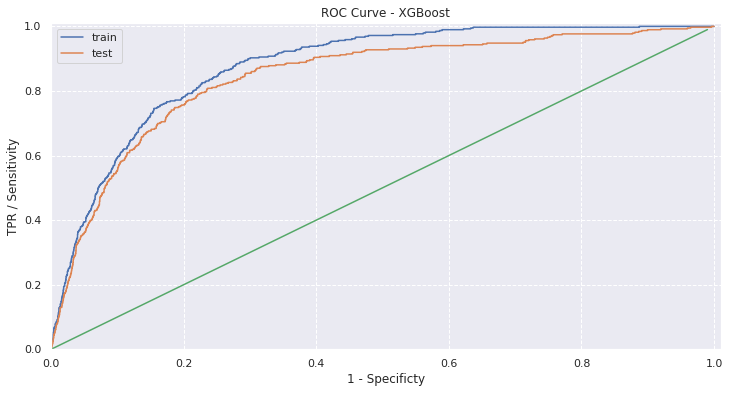

train   = 0.8763383619525416
test    = 0.8430798078603445


In [89]:
y_pred_train_xgb = model.predict(X_train)
y_proba_train_xgb = model.predict_proba(X_train)

y_pred_test_xgb = model.predict(X_test)
y_proba_test_xgb = model.predict_proba(X_test)

roc(y_proba_train_xgb,y_train,y_proba_test_xgb,y_test,'XGBoost')

Reporte del modelo  XGBoost
 
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     10970
           1       0.09      0.88      0.16       386

    accuracy                           0.68     11356
   macro avg       0.54      0.77      0.48     11356
weighted avg       0.96      0.68      0.78     11356

Accuracy:  0.6764705882352942
 
[[7343 3627]
 [  47  339]]


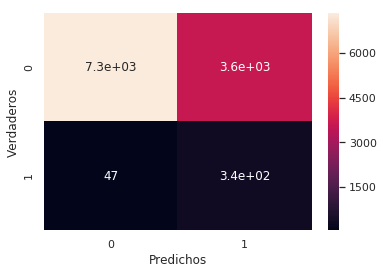

In [71]:
probar_modelo(y_test,y_pred_test_xgb,'XGBoost')

In [90]:
print(model.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


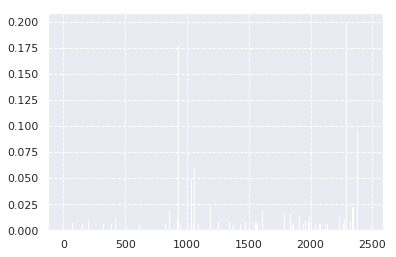

In [100]:

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [0]:
name_dict = {'conexiones': 0,'PAGE_41': 1, 'PAGE_39': 2, 'PAGE_165': 3, 'PAGE_187': 4, 'PAGE_113':5 ,'PAGE_49': 6, 
             'PAGE_69': 7, 'PAGE_287': 8, 'PAGE_110': 9}


In [0]:
lab=['/PRESTAMOS/SOLICITAR','/PRESTAMOS/SOLICITAR-PRECONFIRMACION','/TARJETAS/CONSUMOS/1','/TRANSFERENCIAS/PRECONFIRMARCUENTASPROPIAS',
     '/TARJETAS/CONSUMOS-TARJETA-DEBITO/0','/TARJETAS/CONFIRMACIONPAGO','/INVERSIONES/SELECCIONAR-FECHA-VENCIMIENTO','/INVERSIONES/INICIO',
     '/PRESTAMOS/INICIO','Conexiones']

[Text(0, 0, '/PRESTAMOS/SOLICITAR'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR-PRECONFIRMACION'),
 Text(0, 0, '/TARJETAS/CONSUMOS/1'),
 Text(0, 0, '/TRANSFERENCIAS/PRECONFIRMARCUENTASPROPIAS'),
 Text(0, 0, '/TARJETAS/CONSUMOS-TARJETA-DEBITO/0'),
 Text(0, 0, '/TARJETAS/CONFIRMACIONPAGO'),
 Text(0, 0, '/INVERSIONES/SELECCIONAR-FECHA-VENCIMIENTO'),
 Text(0, 0, '/INVERSIONES/INICIO'),
 Text(0, 0, '/PRESTAMOS/INICIO'),
 Text(0, 0, 'Conexiones')]

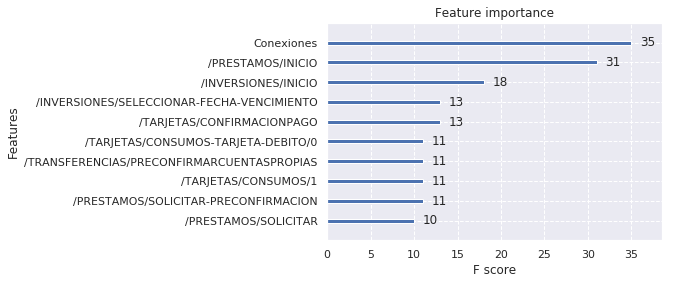

In [130]:
from xgboost import plot_importance
ax=plot_importance(model, max_num_features=10) # top 10 most important features
#ax.set_yticks(name_dict.values())
ax.set_yticklabels(lab)

#a=ax.get_yticks().tolist()
#a[1]='change'
#ax.set_yticklabels(a)


In [0]:
lab2=['/INVERSIONES/INICIO','/TARJETAS/CONFIRMACIONPAGO','NO CATEGORY ASSIGNED > HB : PP','/PRESTAMOS/SOLICITAR-PRECONFIRMACION',
     '/PRESTAMOS/SOLICITAR-SELECCIONAR-CUENTAS','/PRESTAMOS/SOLICITAR-SELECCIONAR-SUBTIPO-PRESTAMO-PER',
     '/PRESTAMOS/INICIO','/PRESTAMOS/SOLICITAR-SELECCIONAR-DESTINO',
     '/PRESTAMOS/SOLICITAR-SELECCIONAR-TIPO-PRESTAMO','/PRESTAMOS/SOLICITAR']

[Text(0, 0, '/INVERSIONES/INICIO'),
 Text(0, 0, '/TARJETAS/CONFIRMACIONPAGO'),
 Text(0, 0, 'NO CATEGORY ASSIGNED > HB : PP'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR-PRECONFIRMACION'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR-SELECCIONAR-CUENTAS'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR-SELECCIONAR-SUBTIPO-PRESTAMO-PER'),
 Text(0, 0, '/PRESTAMOS/INICIO'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR-SELECCIONAR-DESTINO'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR-SELECCIONAR-TIPO-PRESTAMO'),
 Text(0, 0, '/PRESTAMOS/SOLICITAR')]

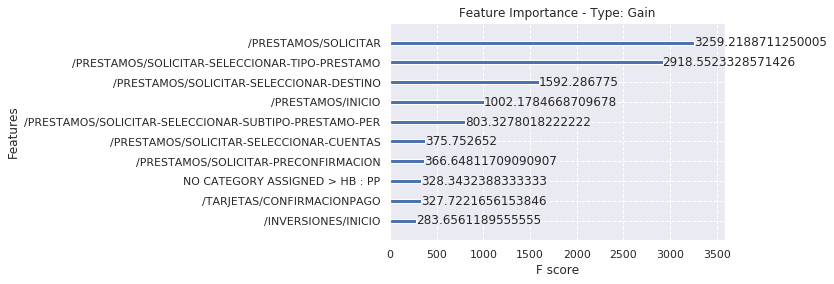

In [136]:
from xgboost import plot_importance
ax=plot_importance(model, max_num_features=10, importance_type="gain") # top 10 most important features
ax.set_title('Feature Importance - Type: Gain')
ax.set_yticklabels(lab2)


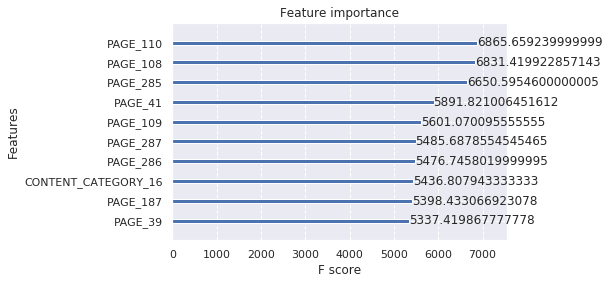

In [132]:
from xgboost import plot_importance
ax=plot_importance(model, max_num_features=10, importance_type="cover") # top 10 most important features


In [96]:
f = 'gain'
model.get_booster().get_score(importance_type= f)

{'CONTENT_CATEGORY_13': 104.220482,
 'CONTENT_CATEGORY_16': 328.3432388333333,
 'CONTENT_CATEGORY_20': 120.944065,
 'CONTENT_CATEGORY_4': 168.019226,
 'CONTENT_CATEGORY_BOTTOM_1': 115.96711966666668,
 'CONTENT_CATEGORY_BOTTOM_13': 97.2269974,
 'CONTENT_CATEGORY_BOTTOM_16': 203.53046141666664,
 'CONTENT_CATEGORY_BOTTOM_20': 99.34038910000001,
 'CONTENT_CATEGORY_BOTTOM_4': 130.71608761666667,
 'CONTENT_CATEGORY_TOP_1': 125.766296,
 'CONTENT_CATEGORY_TOP_5': 105.46199036666667,
 'PAGE_108': 2918.5523328571426,
 'PAGE_109': 803.3278018222222,
 'PAGE_110': 3259.2188711250005,
 'PAGE_113': 153.73815445454548,
 'PAGE_153': 100.452736,
 'PAGE_162': 107.05692066666666,
 'PAGE_163': 118.2992055,
 'PAGE_165': 235.5186174307692,
 'PAGE_187': 327.7221656153846,
 'PAGE_2': 108.48871363333335,
 'PAGE_20': 100.583191,
 'PAGE_202': 109.52948741999998,
 'PAGE_23': 214.03168641000002,
 'PAGE_285': 1592.286775,
 'PAGE_286': 375.752652,
 'PAGE_287': 366.64811709090907,
 'PAGE_345': 99.3865738,
 'PAGE_39': 

#Algoritmo Genetico

In [0]:
!pip install sklearn-deap

     |████████████████████████████████| 153kB 8.0MB/s 


In [0]:
%%time
import sklearn.datasets
import numpy as np
import random

data = sklearn.datasets.load_digits()
X = X_train
y = y_train



from sklearn.model_selection import StratifiedKFold
weigth_0= (float(np.sum(y_train == 1)))/ float(np.sum(y_train== 0))
weigth_1= (float(np.sum(y_train == 0)))/ float(np.sum(y_train == 1))
          
scale_pos = (float(np.sum(y == 0)+float(np.sum(y == 1))))/ float(np.sum(y == 1))

paramgrid = {"n_estimators"     : [30,50,100,300],
             "learning_rate"    : np.linspace(0.001,0.09,100),
             "max_depth"        : [1,2,3, 4, 5, 6,7,8,9,10],
             "min_child_weight" : [1,2, 3, 4,5,6,7,8,9,10,12,14,16,18,20],
             "max_leaf_nodes"   : [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20],
             "gamma"            : np.linspace(0.1,0.6,100),
             "colsample_bytree" : np.linspace(0.5,0.9,100),
             "tree_method"      :['gpu_hist'],
             "eval_metric"      :['auc'],
             "reg_lambda"       :np.linspace(0.01,100,100),
             "reg_alpha"        :np.linspace(0.001,1,100),
             "scale_pos_weight" :np.linspace(scale_pos*0.2,scale_pos*1.8,100)}
   
random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV
cv = EvolutionaryAlgorithmSearchCV(estimator=XGBClassifier(),
                                   params=paramgrid,
                                   scoring="roc_auc",
                                   cv=StratifiedKFold(n_splits=3),
                                   verbose=3,
                                   population_size=200,
                                   gene_mutation_prob=0.05,
                                   gene_crossover_prob=0.5,
                                   tournament_size=5,
                                   generations_number=10,
                                   iid =False)
cv.fit(X, y)

Types [1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2] and maxint [3, 99, 9, 14, 14, 99, 99, 0, 0, 99, 99, 99] detected
--- Evolve in 9000000000000000 possible combinations ---
[CV] n_estimators=50, learning_rate=0.06572727272727272, max_depth=2, min_child_weight=5, max_leaf_nodes=2, gamma=0.4181818181818182, colsample_bytree=0.891919191919192, tree_method=gpu_hist, eval_metric=auc, reg_lambda=83.84, reg_alpha=0.4853636363636364, scale_pos_weight=18.379662953441873 
[CV]  n_estimators=50, learning_rate=0.06572727272727272, max_depth=2, min_child_weight=5, max_leaf_nodes=2, gamma=0.4181818181818182, colsample_bytree=0.891919191919192, tree_method=gpu_hist, eval_metric=auc, reg_lambda=83.84, reg_alpha=0.4853636363636364, scale_pos_weight=18.379662953441873, score=0.853, total=   4.4s
[CV] n_estimators=50, learning_rate=0.06572727272727272, max_depth=2, min_child_weight=5, max_leaf_nodes=2, gamma=0.4181818181818182, colsample_bytree=0.891919191919192, tree_method=gpu_hist, eval_metric=auc, reg_lambda

KeyboardInterrupt: ignored

In [0]:
model= cv.best_estimator_
model.fit(X_train,y_train)

In [0]:

y_pred_train_Best = model.predict(X_train)
y_proba_train_Best = model.predict_proba(X_train)

y_pred_test_Best = model.predict(X_test)
y_proba_test_Best = model.predict_proba(X_test)

roc(y_proba_train_Best,y_train,y_proba_test_Best,y_test)

sm = pd.read_csv("drive/My Drive/Final/sampleSubmission.csv")
sm['SCORE'] = y_proba_test_Best[:,1]
sm.to_csv("drive/My Drive/Final/submission_xgb_ok.csv", index=False)

#Comparacion entre modelos

In [83]:
sns.set(style='darkgrid', font_scale=1, font='Ricty',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
sns.despine()

<Figure size 432x288 with 0 Axes>

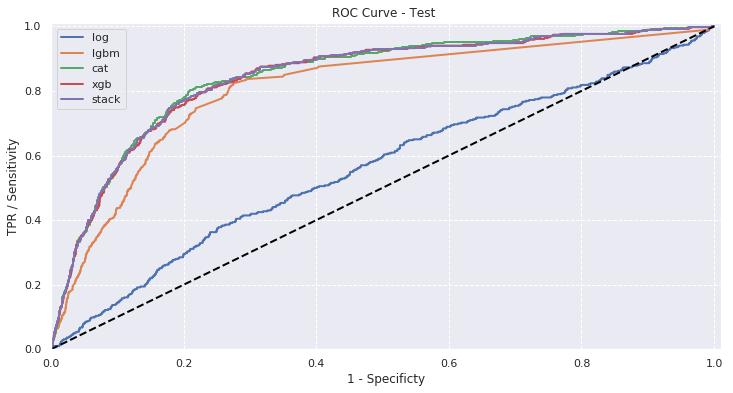

log    = 0.56020470335961
lgbm   = 0.8074073899140849
cat    = 0.8464318607979368
xgb    = 0.8430798078603445
stack  = 0.8447260781878038


In [84]:
fpr_LG,tpr_LG,thr_LG = roc_curve(y_test, y_proba_test_LG[:,1])
fpr_lgbm,tpr_lgbm,thr_lgbm = roc_curve(y_test, y_proba_test_lgbm[:,1])
fpr_cat,tpr_cat,thr_cat = roc_curve(y_test, y_proba_test_cat[:,1])
fpr_xgb,tpr_xgb,thr_xgb = roc_curve(y_test, y_proba_test_xgb[:,1])
fpr_stack,tpr_stack,thr_stack = roc_curve(y_test, y_proba_test_stack[:,1])

plt.figure(figsize=(12,6))
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve - Test ')

plt.plot(fpr_LG,tpr_LG)
plt.plot(fpr_lgbm,tpr_lgbm)
plt.plot(fpr_cat,tpr_cat)
plt.plot(fpr_xgb,tpr_xgb)
plt.plot(fpr_stack,tpr_stack)

r = [0.0, 1.0]
plt.plot(r, r, linestyle='dashed', color='black', linewidth=2, label='random')
#plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['log','lgbm','cat','xgb','stack'])
plt.show()

print('log    =', auc(fpr_LG, tpr_LG))
print('lgbm   =', auc(fpr_lgbm, tpr_lgbm))
print('cat    =', auc(fpr_cat, tpr_cat))
print('xgb    =', auc(fpr_xgb, tpr_xgb))
print('stack  =', auc(fpr_stack, tpr_stack))